In [716]:
from IPython.display import HTML
from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")

<img src='hospital-readmission-aha-media-copy.jpg' width="500" height="300" align="center">

In [717]:
HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

# Hospital Readmissions Data Analysis and Recommendations for Reduction

### Background
In October 2012, the US government's Center for Medicare and Medicaid Services (CMS) began reducing Medicare payments for Inpatient Prospective Payment System hospitals with excess readmissions. Excess readmissions are measured by a ratio, by dividing a hospital’s number of “predicted” 30-day readmissions for heart attack, heart failure, and pneumonia by the number that would be “expected,” based on an average hospital with similar patients. A ratio greater than 1 indicates excess readmissions.

### Exercise Directions

In this exercise, you will:
+ critique a preliminary analysis of readmissions data and recommendations (provided below) for reducing the readmissions rate
+ construct a statistically sound analysis and make recommendations of your own 

More instructions provided below. Include your work **in this notebook and submit to your Github account**. 

### Resources
+ Data source: https://data.medicare.gov/Hospital-Compare/Hospital-Readmission-Reduction/9n3s-kdb3
+ More information: http://www.cms.gov/Medicare/medicare-fee-for-service-payment/acuteinpatientPPS/readmissions-reduction-program.html
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
****

In [760]:
%matplotlib inline
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bokeh.plotting as bkp
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import statsmodels.stats.api as sms
from scipy import stats
from IPython.display import display, Math, Latex
import pylab
import warnings
warnings.filterwarnings("ignore")

In [761]:
# read in readmissions data provided
hospital_read_df = pd.read_csv('data/cms_hospital_readmissions.csv')

In [762]:
hospital_read_df.head(3)

,Hospital Name,Provider Number,State,Measure Name,Number of Discharges,Footnote,Excess Readmission Ratio,Predicted Readmission Rate,Expected Readmission Rate,Number of Readmissions,Start Date,End Date
0,FROEDTERT MEMORIAL LUTHERAN HOSPITAL,520177,WI,READM-30-HIP-KNEE-HRRP,242,NaN,1.9095,10.8,5.6,38.0,07/01/2010,06/30/2013
1,PROVIDENCE HOSPITAL,90006,DC,READM-30-HIP-KNEE-HRRP,247,NaN,1.7521,9.2,5.3,33.0,07/01/2010,06/30/2013
2,BEAUFORT COUNTY MEMORIAL HOSPITAL,420067,SC,READM-30-HIP-KNEE-HRRP,586,NaN,1.5836,7.6,4.8,53.0,07/01/2010,06/30/2013


In [763]:
#replace spaces 
col_list=[i.replace(" ", "_") for i in hospital_read_df.columns]
hospital_read_df.columns=col_list

In [764]:
hospital_read_df.columns

Index(['Hospital_Name', 'Provider_Number', 'State', 'Measure_Name',
       'Number_of_Discharges', 'Footnote', 'Excess_Readmission_Ratio',
       'Predicted_Readmission_Rate', 'Expected_Readmission_Rate',
       'Number_of_Readmissions', 'Start_Date', 'End_Date'],
      dtype='object')

In [766]:
def boxPlot(variable):
    sns.set_style("whitegrid")
    #sns.load_dataset("tips")
    sns.boxplot(x=variable)
    return plt.show(),plt.clf()

In [767]:
def CDFPlot(variable):
    lower,upper=variable.min(),variable.max()
    mu,sigma = variable.mean(),variable.std()
    values = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
#    values = np.random.normal(mu, sigma, 10000)
    sns.kdeplot(variable,cumulative=True,label=variable.name+" CDF",color='b')
    sns.kdeplot(values.rvs(1000),cumulative=True,label="Gaussian CDF",color='r')
    plt.suptitle("Cumulative Distribution Frequency of Temperature Against Normal Gaussian distribution.")
    plt.figure()
    return plt.show(),plt.clf()

**KDE of Number of Discharges**

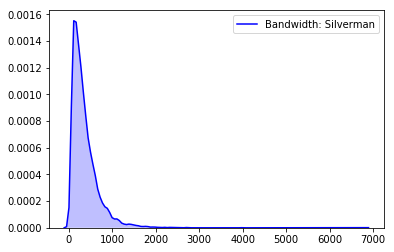

In [725]:
dis_array=np.array(hospital_read_df.Number_of_Discharges.replace('Not Available',0))
sns.kdeplot(dis_array,bw='silverman',label="Bandwidth: Silverman", shade=True, color="b")

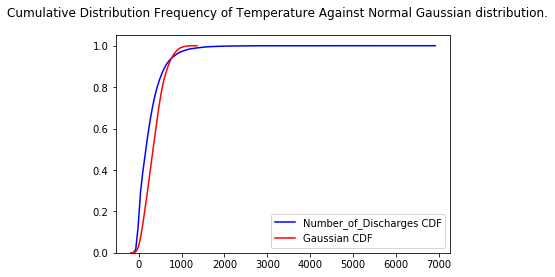

<Figure size 432x288 with 0 Axes>

(None, None)

<Figure size 432x288 with 0 Axes>

In [726]:
dis_array=hospital_read_df
dis_array['Number_of_Discharges']=dis_array.Number_of_Discharges.replace('Not Available',0)
dis_array['Number_of_Discharges']=dis_array.Number_of_Discharges.astype(int)
CDFPlot(dis_array['Number_of_Discharges'])

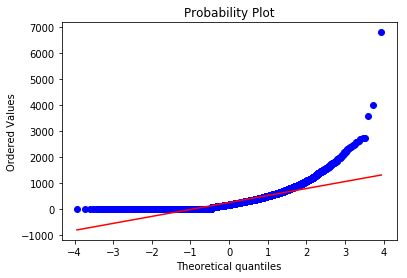

In [727]:
stats.probplot(dis_array['Number_of_Discharges'], dist="norm", plot=pylab)
pylab.show()

Note: Discharges does NOT appear to be normally distributed.

**KDE of Excess Readmission Ratio**

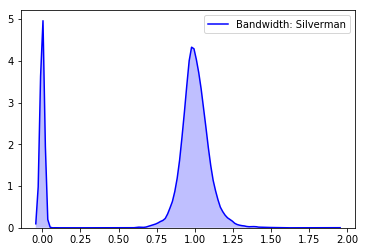

In [728]:
excess_array=hospital_read_df['Excess_Readmission_Ratio'].fillna(0)
sns.kdeplot(excess_array,bw='silverman',label="Bandwidth: Silverman", shade=True, color="b")

*Note: Here we see almost two seperate distributions, one distribution centered around zero and another centered around one. The zero one is probably created mostly because I filled the missing values with zero.*

**KDE of Number of Readmissions**

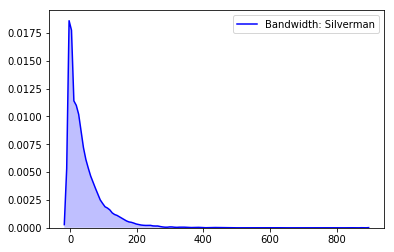

In [1010]:
numread_array=hospital_read_df['Number_of_Readmissions'].fillna(0)
sns.kdeplot(numread_array,bw='silverman',label="Bandwidth: Silverman", shade=True, color="b")

****
## Preliminary Analysis

In [770]:
# deal with missing and inconvenient portions of data 
clean_hospital_read_df = hospital_read_df[hospital_read_df['Number_of_Discharges'] != 'Not Available']
clean_hospital_read_df.Number_of_Discharges = clean_hospital_read_df.Number_of_Discharges.astype(int)
clean_hospital_read_df = clean_hospital_read_df.sort_values('Number_of_Discharges')

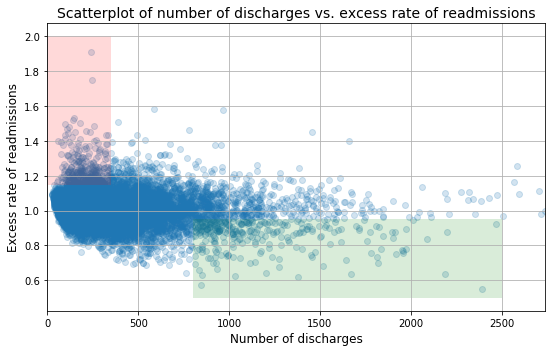

In [771]:
# generate a scatterplot for number of discharges vs. excess rate of readmissions
# lists work better with matplotlib scatterplot function
x = [a for a in clean_hospital_read_df['Number_of_Discharges'][81:-3]]
y = list(clean_hospital_read_df['Excess_Readmission_Ratio'][81:-3])

fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(x, y,alpha=0.2)

ax.fill_between([0,350], 1.15, 2, facecolor='red', alpha = .15, interpolate=True)
ax.fill_between([800,2500], .5, .95, facecolor='green', alpha = .15, interpolate=True)

ax.set_xlim([0, max(x)])
ax.set_xlabel('Number of discharges', fontsize=12)
ax.set_ylabel('Excess rate of readmissions', fontsize=12)
ax.set_title('Scatterplot of number of discharges vs. excess rate of readmissions', fontsize=14)

ax.grid(True)
fig.tight_layout()

****
### Exercise

Include your work on the following **in this notebook and submit to your Github account**. 

A. Do you agree with the above analysis and recommendations? Why or why not?
   
B. Provide support for your arguments and your own recommendations with a statistically sound analysis:

   1. Setup an appropriate hypothesis test.
   2. Compute and report the observed significance value (or p-value).
   3. Report statistical significance for $\alpha$ = .01. 
   4. Discuss statistical significance and practical significance. Do they differ here? How does this change your recommendation to the client?
   5. Look at the scatterplot above. 
      - What are the advantages and disadvantages of using this plot to convey information?
      - Construct another plot that conveys the same information in a more direct manner.



You can compose in notebook cells using Markdown: 
+ In the control panel at the top, choose Cell > Cell Type > Markdown
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
****

****

## Preliminary Report

Read the following results/report. While you are reading it, think about if the conclusions are correct, incorrect, misleading or unfounded. Think about what you would change or what additional analyses you would perform.

**A. Initial observations based on the plot above**
+ Overall, rate of readmissions is trending down with increasing number of discharges
+ With lower number of discharges, there is a greater incidence of excess rate of readmissions (area shaded red)
+ With higher number of discharges, there is a greater incidence of lower rates of readmissions (area shaded green) 

**B. Statistics**
+ In hospitals/facilities with number of discharges < 100, mean excess readmission rate is 1.023 and 63% have excess readmission rate greater than 1 
+ In hospitals/facilities with number of discharges > 1000, mean excess readmission rate is 0.978 and 44% have excess readmission rate greater than 1 

**C. Conclusions**
+ There is a significant correlation between hospital capacity (number of discharges) and readmission rates. 
+ Smaller hospitals/facilities may be lacking necessary resources to ensure quality care and prevent complications that lead to readmissions.

**D. Regulatory policy recommendations**
+ Hospitals/facilties with small capacity (< 300) should be required to demonstrate upgraded resource allocation for quality care to continue operation.
+ Directives and incentives should be provided for consolidation of hospitals and facilities to have a smaller number of them with higher capacity and number of discharges.

**Overall, rate of readmissions is trending down with increasing number of discharges**

In [772]:
#Overall, rate of readmissions is trending down with increasing number of discharges
comparison=(clean_hospital_read_df['Excess_Readmission_Ratio']>=0)
readmission_set=clean_hospital_read_df[comparison]

discharges=readmission_set.Number_of_Discharges
readmissions=readmission_set.Excess_Readmission_Ratio

In [773]:
clean_hospital_read_df['Start_Date']=pd.to_datetime(clean_hospital_read_df['Start_Date'], format = '%m/%d/%Y',  errors='coerce')
clean_hospital_read_df['End_Date']=pd.to_datetime(clean_hospital_read_df['End_Date'], format = '%m/%d/%Y',  errors='coerce')
clean_hospital_read_df['Time_Frame']=clean_hospital_read_df['Start_Date']-clean_hospital_read_df['End_Date']

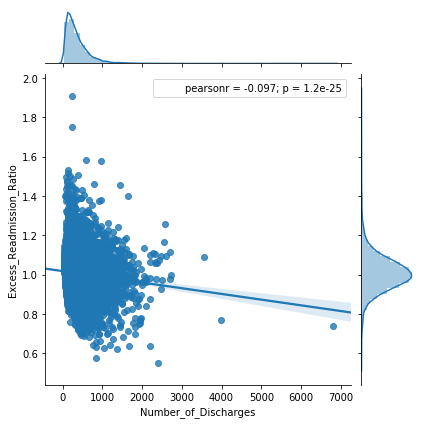

In [774]:
sns.jointplot((discharges),readmissions, kind="reg")

Log of Discharges

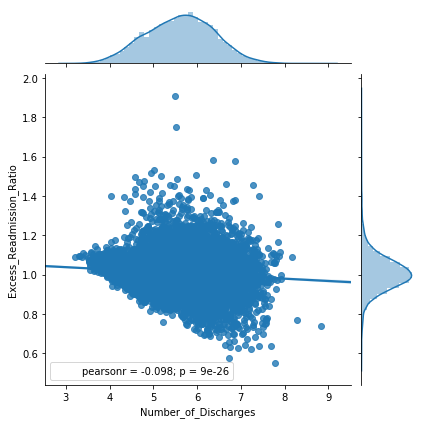

In [775]:
sns.jointplot(np.log(discharges),readmissions, kind="reg")

**Explanation:** *A quick plotting of the relationship between 'Number of Readmissions' and 'Number of Discharges' seems to initially somewhat support the claim made in the report; however the relationship of the factors doesn't appear to be linear. We can also see by the pearsonr that they don't predict each other particularly well. Judging by the distribution of the Excess_Readmission_Ratio I would almost say that it appears to follow a Guassian curve and would therefore appear to follow a random pattern centered around 1. The discharges on the otherhand seem to follow a Pareto distribution / Power-Law, Weibull, or some kind of sloping distribution.*

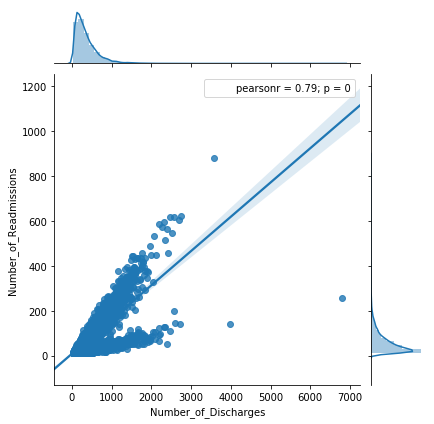

In [776]:
comparison=(clean_hospital_read_df['Number_of_Readmissions']>=0)
readmission_set=clean_hospital_read_df[comparison]

discharges=readmission_set.Number_of_Discharges
readmissions=readmission_set.Number_of_Readmissions
sns.jointplot(discharges,readmissions, kind="reg")

Log of Readmissions and Discharges

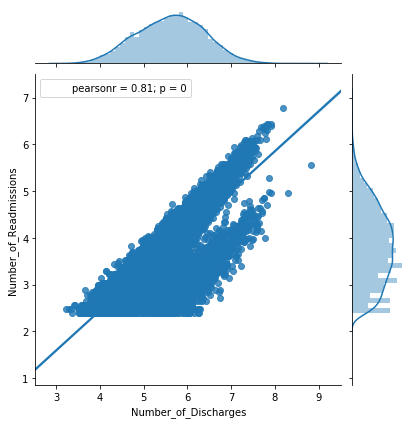

In [777]:
sns.jointplot(np.log(discharges),np.log(readmissions), kind="reg")

**Note:** *The preliminary report states 'rate of readmissions is trending down with increasing number of discharges'; however it is important to point out that they plotted 'Excess Readmission Ratio' and not actual 'readmissions' against number of discharges which tell a different story. Here we can see the relationship between 'readmissions' and 'discharges', in general trends positively with increased number of discharges.*

**A. Initial observations based on the plot above**

    Overall, rate of readmissions is trending down with increasing number of discharges
    With lower number of discharges, there is a greater incidence of excess rate of readmissions (area shaded red)
    With higher number of discharges, there is a greater incidence of lower rates of readmissions (area shaded green)

**B. Statistics**

    In hospitals/facilities with number of discharges < 100, mean excess readmission rate is 1.023 and 63% have excess readmission rate greater than 1
    In hospitals/facilities with number of discharges > 1000, mean excess readmission rate is 0.978 and 44% have excess readmission rate greater than 1


In [778]:
# split data
comparison = (clean_hospital_read_df['Number_of_Discharges'] < 100) & (clean_hospital_read_df['Number_of_Discharges'] > 0)
lower_discharge  = clean_hospital_read_df[comparison]
comparison = (clean_hospital_read_df['Number_of_Discharges'] > 1000)
higher_discharge = clean_hospital_read_df[comparison]

__________________________________________________

**Total Discharges**

In [779]:
clean_hospital_read_df.groupby(['Time_Frame']).sum()

,Provider_Number,Number_of_Discharges,Footnote,Excess_Readmission_Ratio,Predicted_Readmission_Rate,Expected_Readmission_Rate,Number_of_Readmissions
Time_Frame,,,,,,,
-1095 days,2983436838,4201765,567.0,11583.271,206765.4,205401.9,731597.0


In [780]:
print('The total daily discharge rate among all hospitals is approximately:',4201765/1095,'\nThe total annual discharge rate among all hospitals is approximately:',(4201765/1095)*365)

The total daily discharge rate among all hospitals is approximately: 3837.228310502283 
The total annual discharge rate among all hospitals is approximately: 1400588.3333333333


Mean Discharges

In [781]:
clean_hospital_read_df.groupby(['Time_Frame']).mean()

,Provider_Number,Number_of_Discharges,Footnote,Excess_Readmission_Ratio,Predicted_Readmission_Rate,Expected_Readmission_Rate,Number_of_Readmissions
Time_Frame,,,,,,,
-1095 days,257681.537226,362.909397,7.0,1.007504,17.984292,17.865695,63.633731


_______________________________

**Lower Discharge (<100)**

Sum

In [782]:
lower_discharge.groupby(['Time_Frame']).sum()

,Provider_Number,Number_of_Discharges,Footnote,Excess_Readmission_Ratio,Predicted_Readmission_Rate,Expected_Readmission_Rate,Number_of_Readmissions
Time_Frame,,,,,,,
-1095 days,299589975,88764,0.0,1214.8706,23800.3,23322.8,18925.0


In [783]:
print('The daily discharge rate for the discharges (<100) among all hospitals is approximately:',88764/1095,'\nThe annual discharge rate among all hospitals is approximately:',(88764/1095)*365)

The daily discharge rate for the discharges (<100) among all hospitals is approximately: 81.06301369863014 
The annual discharge rate among all hospitals is approximately: 29588.000000000004


Checking the claim claim about percent of excess readmissions

In [784]:
comparison=lower_discharge.Excess_Readmission_Ratio>0
total_excess=len(lower_discharge[comparison]['Hospital_Name'])
comparison=lower_discharge.Excess_Readmission_Ratio>1
lower_excess=len(lower_discharge[comparison]['Hospital_Name'])
print('Percent excess readmission greater than 1:',lower_excess/total_excess)

Percent excess readmission greater than 1: 0.6321548821548821


Mean

In [785]:
lower_discharge.groupby(['Time_Frame']).mean()

,Provider_Number,Number_of_Discharges,Footnote,Excess_Readmission_Ratio,Predicted_Readmission_Rate,Expected_Readmission_Rate,Number_of_Readmissions
Time_Frame,,,,,,,
-1095 days,252180.113636,74.717172,NaN,1.022618,20.033923,19.631987,15.930135


________________________________________

**Higher Discharge (>1000)**

Sum

In [786]:
higher_discharge.groupby(['Time_Frame']).sum()

,Provider_Number,Number_of_Discharges,Footnote,Excess_Readmission_Ratio,Predicted_Readmission_Rate,Expected_Readmission_Rate,Number_of_Readmissions
Time_Frame,,,,,,,
-1095 days,116477200,640527,0.0,452.9693,7436.5,7457.4,100097.0


In [787]:
print('The daily discharge rate for the discharges (>1000) among all hospitals is approximately:',640527/1095,'\nThe annual discharge rate among all hospitals is approximately:',(640527/1095)*365)

The daily discharge rate for the discharges (>1000) among all hospitals is approximately: 584.9561643835616 
The annual discharge rate among all hospitals is approximately: 213508.99999999997


Checking the claim claim about percent of excess readmissions

In [788]:
comparison=higher_discharge.Excess_Readmission_Ratio>0
total_excess=len(higher_discharge[comparison]['Hospital_Name'])
comparison=higher_discharge.Excess_Readmission_Ratio>1
lower_excess=len(higher_discharge[comparison]['Hospital_Name'])
print('Percent excess readmission greater than 1:',lower_excess/total_excess)

Percent excess readmission greater than 1: 0.4449244060475162


Mean

In [789]:
higher_discharge.groupby(['Time_Frame']).mean()

,Provider_Number,Number_of_Discharges,Footnote,Excess_Readmission_Ratio,Predicted_Readmission_Rate,Expected_Readmission_Rate,Number_of_Readmissions
Time_Frame,,,,,,,
-1095 days,251570.62635,1383.427646,NaN,0.978335,16.061555,16.106695,216.192225


**Explanation:** So far for the most part initial observations made in the report seem to make some sense. I can easily reproduce all of the statistics quoted in the report. I suspect there may be a spurious correlation or a relationship that is being unexplored in the initial report and may not exist in the data available.

________________

**C. Conclusions**

    There is a significant correlation between hospital capacity (number of discharges) and readmission rates.
    Smaller hospitals/facilities may be lacking necessary resources to ensure quality care and prevent complications that lead to readmissions.

**D. Regulatory policy recommendations**

    Hospitals/facilties with small capacity (< 300) should be required to demonstrate upgraded resource allocation for quality care to continue operation.
    Directives and incentives should be provided for consolidation of hospitals and facilities to have a smaller number of them with higher capacity and number of discharges.


In [873]:
clean_hospital_read_df = (hospital_read_df[hospital_read_df['Number_of_Discharges']!= 'Not Available']) 
clean_hospital_read_df = clean_hospital_read_df[clean_hospital_read_df['Excess_Readmission_Ratio'] >= 0]
clean_hospital_read_df.Number_of_Discharges = clean_hospital_read_df.Number_of_Discharges.astype(int)
clean_hospital_read_df['Hospital_Class']='Medium'
bin1=clean_hospital_read_df.Number_of_Discharges<300
bin2=clean_hospital_read_df.Number_of_Discharges>1000
clean_hospital_read_df.Hospital_Class[bin1]='Small'
clean_hospital_read_df.Hospital_Class[bin2]='Large'
comparison=clean_hospital_read_df['Excess_Readmission_Ratio']>1
clean_excess_set=clean_hospital_read_df[comparison]

Limiting to only hospitals with Excess Readmissions.

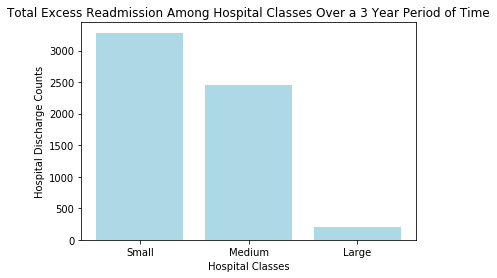

In [1012]:
dictionary=dict(clean_excess_set.Hospital_Class.value_counts())
plt.bar(list(dictionary.keys()), dictionary.values(), color='lightblue')
plt.title('Total Excess Readmission Among Hospital Classes Over a 3 Year Period of Time')
plt.ylabel('Hospital Discharge Counts')
plt.xlabel('Hospital Classes')
plt.show()

**Explanation:** Here it is much easier to see that the 'Small' group (<300) seems to have a higher rate of excess re-admissions, particularly compared to the 'Large' group (>1000). With a graph such as this it kind of makes a statical test almost a moot point. Furthermore I would say this is a much better way of displaying the information as it is simpler gets straight to the point. The scatterplot above may look fancy but would be difficult to understand without explanation.

**Caveat:** One caveat of the information above is that smaller hospitals may have a quicker turn-around times with a higher rate of 'catch-and-release' leading to a greater amount of readmissions, because obviously they have fewer beds. 

**But what if they don't? What if the graph above is slightly misleading? What if the average rate of hospital readmission is no different than the other hospital classes?**

In [919]:
groupby_classes=clean_excess_set.groupby(['Hospital_Class']).mean()
groupby_classes

,Provider_Number,Number_of_Discharges,Footnote,Excess_Readmission_Ratio,Predicted_Readmission_Rate,Expected_Readmission_Rate,Number_of_Readmissions
Hospital_Class,,,,,,,
Large,246687.689320,1368.834951,NaN,1.078737,19.688350,18.354854,271.067961
Medium,256003.197143,513.402041,NaN,1.077532,19.048898,17.775510,102.127755
Small,253778.120012,165.309473,NaN,1.069427,19.159762,18.054371,34.385014


Looking at the above chart it would seem as though there really isn't any different on average between the three different classes; so are they statistically different from each other or not?


### Test assumptions

In [907]:
clean_excess_set.Hospital_Class.value_counts()

Small     3283
Medium    2450
Large      206
Name: Hospital_Class, dtype: int64

**Independance:** The sample sizes are >10. We don't know if the observations are independant from each other. There are duplicate names in the dataset, this can easily be demonstrated. I will carry on with the assumption that we are dealing with independant data.

In [917]:
print('Number of names in the limited dataset:',len(clean_excess_set.Hospital_Name),'\nNumber of unique names in the limited dataset:',len(set(clean_excess_set.Hospital_Name)))

Number of names in the limited dataset: 5939 
Number of unique names in the limited dataset: 2377


**Normality:** As shown previously discharges don't appear to follow a normal distribution; however the Excess Readmission Ratio does apppear to be normal. 

Total Excess Readmission Ratio KDE

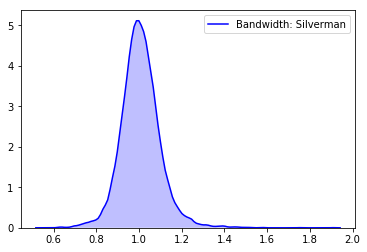

In [927]:

sns.kdeplot(clean_hospital_read_df.Excess_Readmission_Ratio,bw='silverman',label="Bandwidth: Silverman", shade=True, color="b")

Small Excess Readmission Ratio

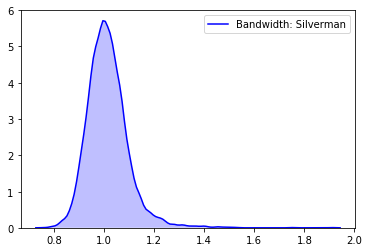

In [934]:
comparison=clean_hospital_read_df.Hospital_Class=='Small'
sns.kdeplot(clean_hospital_read_df[comparison].Excess_Readmission_Ratio,bw='silverman',label="Bandwidth: Silverman", shade=True, color="b")

Medium Excess Readmission Ratio

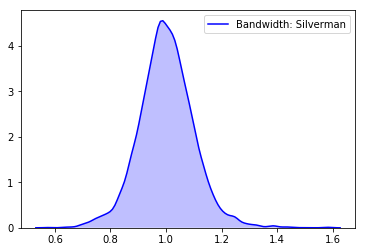

In [935]:
comparison=clean_hospital_read_df.Hospital_Class=='Medium'
sns.kdeplot(clean_hospital_read_df[comparison].Excess_Readmission_Ratio,bw='silverman',label="Bandwidth: Silverman", shade=True, color="b")

Large Excess Readmission Ratio

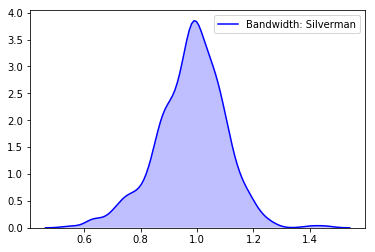

In [936]:
comparison=clean_hospital_read_df.Hospital_Class=='Large'
sns.kdeplot(clean_hospital_read_df[comparison].Excess_Readmission_Ratio,bw='silverman',label="Bandwidth: Silverman", shade=True, color="b")

**Equal Variances:** In order to achieve equal variances and maintain homoscedasticity between each seperate hospital class I sampled 100 items from each group.

In [976]:
print('If we fail to reject the null hypothesis then the data would seem consistent with the claim that there is no difference between the sample means. ')
Math(r'H_{0} : \mu_{small} = \mu_{medium} = \mu_{large} = 0 \\ H_{1} : \mu_{small} \neq \mu_{medium} \neq \mu_{large} \neq 0')

If we fail to reject the null hypothesis then the data would seem consistent with the claim that there is no difference between the sample means. 


<IPython.core.display.Math object>

**One-way Analysis of Variance**

In [979]:
#https://newonlinecourses.science.psu.edu/stat501/node/259/
Math(r'Y_{ij} = \mu + \tau_i + \epsilon_{ij} \, ')

<IPython.core.display.Math object>

**Test**

In [990]:
bin1=clean_hospital_read_df.Hospital_Class=='Small'
bin2=clean_hospital_read_df.Hospital_Class=='Medium'
bin3=clean_hospital_read_df.Hospital_Class=='Large'

small=clean_hospital_read_df[bin1].Excess_Readmission_Ratio
small_sample_100=small.sample(100, replace=False)
small_std=small_sample_100.std()    

medium=clean_hospital_read_df[bin2].Excess_Readmission_Ratio
med_sample_100=medium.sample(100, replace=False)
med_std=med_sample_100.std()

large=clean_hospital_read_df[bin3].Excess_Readmission_Ratio
large_sample_100=large.sample(100, replace=False)
large_std=large_sample_100.std()

lower,upper = sms.CompareMeans(sms.DescrStatsW(large_sample_100), sms.DescrStatsW(small_sample_100)).tconfint_diff(alpha = 0.01, usevar='unequal')
fstat, pval = stats.f_oneway(small_sample_100, med_sample_100, large_sample_100)
print('F-statistic:',fstat,'95% C.I.:',(lower,upper),'\np-value:',pval)

F-statistic: 4.881155872294524 95% C.I.: (-0.07822871228249453, -0.008455287717505235) 
p-value: 0.008207963886706467


**Conclusion:** With a (pvalue<.05) we reject the null hypothesis and find that the data do not support the null model's hypothesis that the sample means are equal.

**One-sample T-test**

In [1004]:
print('If we fail to reject the null hypothesis then the data would seem consistent with the claim that the small sample population body temperature is equivalent to 98.6. ')
Math(r'H_{0} : \bar x_{small} - \bar x_{large} = 0 \\ H_{1} : \bar x_{small} - \bar x_{large} > 0 ')


If we fail to reject the null hypothesis then the data would seem consistent with the claim that the small sample population body temperature is equivalent to 98.6. 


<IPython.core.display.Math object>

In [1005]:
Math(r't: = \dfrac{(x_i - \mu_0)}{ \dfrac{s_i}{ \sqrt{n}}}')

<IPython.core.display.Math object>

In [1006]:
print('Large sample mean:',large_sample_100.mean())
print('Small sample mean:',small_sample_100.mean())

Large sample mean: 0.9667150000000003
Small sample mean: 1.0100570000000002


In [1007]:
ttest = (small_sample_100.mean()-large_sample_100.mean()) / (small_std / np.sqrt(100))

ttest = stats.ttest_1samp(small_sample_100, popmean=large_sample_100.mean())
print('t-statistic:', ttest[0],' \n p-value:', ttest[1])
if ttest[1]<.05:
    print('Our sample mean:',small_sample_100.mean())
    print("Conclusion: We reject the null hypothesis and find that the data is not consistent with the claim that the small sample mean is equivalent to the large sample mean.")
else:
    print("Conclusion: We fail to reject the null hypothesis and find that the data is not consistent with the claim that the small sample mean is equivalent to the large sample mean.")

t-statistic: 5.622626383693136  
 p-value: 1.741699532040905e-07
Our sample mean: 1.0100570000000002
Conclusion: We reject the null hypothesis and find that the data is not consistent with the claim that the small sample mean is equivalent to the large sample mean.


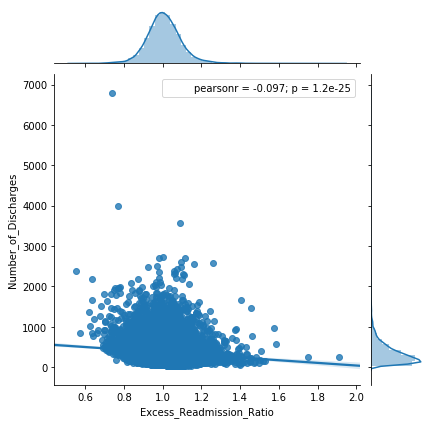

In [1008]:
n=len(clean_hospital_read_df.Number_of_Discharges)
y=clean_hospital_read_df.Number_of_Discharges
x=clean_hospital_read_df.Excess_Readmission_Ratio
sns.jointplot(x,y, kind="reg")

In [1009]:
n=len(clean_hospital_read_df.Number_of_Discharges)
a=0.05

def r_to_z(r):
    return math.log((1 + r) / (1 - r)) / 2.0

def z_to_r(z):
    e = math.exp(2 * z)
    return((e - 1) / (e + 1))

def r_confidence_interval(r, alpha, n):
    z = r_to_z(r)
    se = 1.0 / math.sqrt(n - 3)
    z_crit = stats.norm.ppf(1 - alpha/2)  # 2-tailed z critical value

    lo = z - z_crit * se
    hi = z + z_crit * se

    # Return a sequence
    return (z_to_r(lo), z_to_r(hi))

stat,pval=stats.pearsonr(x, y)
upper,lower=r_confidence_interval(r_to_z(stat), 0.05, n)
print('Pearson-R:',stat,'\n95% CI: ',(upper,lower),'\np-value:',pval,)

Pearson-R: -0.09739794351079355 
95% CI:  (-0.11578039494410854, -0.0795703170182804) 
p-value: 1.222547377680967e-25


### Final Conclusions:

- After many linear graphs, a histogram, an analysis of variance, and a one-sided t-test my findings concur with most of the claims made in the report. I have found that the average number of excess readmission rates do increase based on the number of discharges. I have also been able to easily reproduce the quoted statistics in the report. 
- I do NOT concur with the way the report states "There is a significant correlation between hospital capacity and readmission rates." Not because it isn't necessarily true, but that it is a bit misleading. Although I have been able to show statistical significance with the relationship between excess readmission and discharges; the pearson correlation coefficient isn't particularly convincing. The statement conveys the difference between statistical significance and practical significance in the problem. Also I feel they should adjust their language such that it should state, "there seems to be a relationship between hospital capacity and excess readmission rates". 

**The Graph:**

- The bad: Everything about the graph above is terrible in my opinion. Not that it doesn't accurately convey the information; it is bad because it conveys too much information. There is just too much cognitive noise required to understand the graph properly, I fully believe that graphs should convey their meaning as easily/simply as possible without having to strain. I also don't feel the graph does the report justice as it doesn't adequately support the claims made in the report. 
- The Good: The data is plotted.


**My Graph:** Call me simplistic but honestly the more I think about it the more I am happy with the below graph. Although this graph is dramatically different than the one in the report; I feel it does a better job of getting presumably the original point across to the client without all the crap.

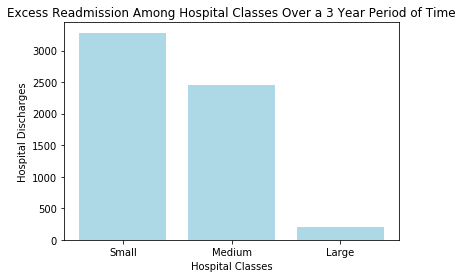

In [1015]:
dictionary=dict(clean_excess_set.Hospital_Class.value_counts())
plt.bar(list(dictionary.keys()), dictionary.values(), color='lightblue')
plt.title('Excess Readmission Among Hospital Classes Over a 3 Year Period of Time')
plt.ylabel('Hospital Discharges')
plt.xlabel('Hospital Classes')
plt.show()